In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%config InlineBackend.figure_format = 'svg'

font = {'family' : 'serif',
        'size'   : 17,
        'weight' : 'normal'
       }

plt.rc('font', **font)

plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=20)
plt.rc('legend', fontsize=18)
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[T2A]{fontenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# Multi-armed bandits

<img src="https://miro.medium.com/max/339/0*l7Ra4R_CpJfc-hjz.png">

## Notation

* Actions: $\mathcal A = \{a_1, \ldots, a_k\}$ ($k$ levers)
* $A_t \in \mathcal A$ — action selected by the agent at time step $t$
* Action value: $q(a) = \mathbb E[R_t | A_t = a]$
* Optimal value: $v_* = \max\limits_{a \in \mathcal A} q(a)$
* Optimal action: $a_* = \arg\max\limits_{a \in \mathcal A} q(a)$
* Regret: $\Delta_a = v_* - q(a)$
* $Q_t(a)$ — estimation of $q(a)$ at time step $t$

The goal is to maximize expected cumulative reward

$$
    \sum\limits_{i=1}^t q(A_i) = \sum\limits_{i=1}^t \mathbb E[R_i | A_i = a] \to \max
$$

This is the same as to minimize cumulative regret:

$$
    \sum\limits_{i=1}^t \Delta_{A_i} \to \min
$$

## Sample-average method

$$
Q_t(a) = \frac 1{N_t(a)}\sum\limits_{i=1}^{t-1} R_i \mathbb I[A_i=a],
$$

$$
\quad N_t(a) = \sum\limits_{i=1}^{t-1} \mathbb I[A_i=a]
$$

$N_t(a)$ is the number of times the action $a$ was taken. If $N_t(a) = 0$, then $Q_t(a)=0$ or some other default value.

**Q.** Suppose $k=2$. What are $Q_5(a)$ and $Q_5(b)$?

|   | 1  | 2 | 3  | 4  | 5|
|:-:|:-:|:-:|---|---|---|
| $a$ |  0 |   |   |   | ? |
| $b$ |   |  1 | 0  | 0  | ? |

## Greedy policy

Select action with the highest estimation:

$$
    A_t = \arg\max\limits_{a\in \mathcal A} Q_t(a), \text{ or } \pi_t(a) = \mathbb I[A_t = \arg\max\limits_{a\in \mathcal A} Q_t(a)]
$$

**Q.** According to greedy policy, what is $A_5$ in the previous example?

## $\varepsilon$-greedy policy

* With probability $1-\varepsilon$ select greedy action 

$$
A_t = \arg\max\limits_{a\in \mathcal A} Q_t(a)
$$

* With probability $\varepsilon$ select a random action

**Q.** If we follow $\varepsilon$-greedy strategy, what is the probability of selection of the greedy action?

## Testbed

A testbed for k-armed bandits is created in class `Testbed`. The reward produced by each arm is taken from $\mathcal N(a_i, 1)$, where $a_i$ are in turn sampled from the standard normal distribuion.

In [2]:
class Testbed:
    def __init__(self, k=10, initial_value=0.0, n_runs=2000, random_state=42):
        """
            Creates a testbed for k-armed bandits. 
            The reward produced by each arm is taken from N(a_i, 1),
            where a_i are in turn sampled from the standard normal distribuion.

            Parameters
            ----------
            k : int
                The number of arms.
            initial_value : float, optional
                The default value for Q_1(a).
            n_runs : int, optional
                The number of independent copies of the testbed, 2000 by default.
            random_state: int, optional
                The value use to reseed the random number generator.
        """
        self.k = k
        np.random.seed(random_state)
        self.means = np.random.randn(n_runs, k)
        self.sample_averages = initial_value*np.ones((n_runs, k))
        self.n_tries = np.zeros((n_runs, k))
        
    def plot(self, idx, n_samples=3000):
        """
            Plots k violin plots (one plot per arm) showing the true distribution of the rewards.
            
            Parameters
            ----------
            idx : int
                The index of the testbed to be plotted.
            n_samples : int, optional
                The number of samples taken from the gaussian distribution.
        """
        plt.figure(figsize=(9, 5))
        samples = norm.rvs(size=(n_samples, self.k), loc=self.means[idx, :])
        violin_parts = plt.violinplot(samples, showmeans=True, showextrema=False, points=1000)
        for pc in violin_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_edgecolor('black')
        plt.grid(ls=':')
        plt.xticks(np.arange(1, self.k + 1))
        plt.yticks(np.arange(-5, 6))
        plt.show();
        
    def optimal_action(self, idx=None):
        """
            Returns the action with maximal average reward.
            
            Parameters
            ----------
            idx : int or None, optional
                If None, returns the best action for all testbeds, otherwise only for testbed with index idx.
                
            Returns
            ----------
            index_array : ndarray or int
                Index of optimal action in each testbed.
        """
        if idx is None:
            return np.argmax(self.means, axis=1)
        return np.argmax(self.means[idx, :])
    
    def greedy_action(self, eps=0):
        """
            Returns the action according to 𝜺-greeedy policy
            
            Parameters
            ----------
            eps : float, optional
                The probability of taking the random action. By default the policy is greedy (𝜺=0)
                
            Returns
            ----------
            index_array : ndarray
                Index of selected action in each testbed.
        """
        mask = np.random.rand(self.means.shape[0])
        actions = np.argmax(self.sample_averages, axis=1)
        actions[mask <= eps] = np.random.randint(10, size=(mask <= eps).sum())
        return actions
    
    def ucb_action(self, t, c=0):
        """
            Selects action according to UCB algorithm.
            
            Parameters
            ----------
            t : int
                Time step.
            с : float, optional
                Specifies the size of the upper confidence bound. c=0 (default) means greedy action.
                
            Returns
            ----------
            index_array : ndarray
                Index of selected action in each testbed.
        """
        EPS = 1e-10
        self.n_tries[self.n_tries == 0] = EPS
        actions = np.argmax(self.sample_averages + c*np.sqrt(np.log(t)/self.n_tries), axis=1)
        return actions
    
    def step(self, action_indices, alpha=None, nonstationary=False):
        """
            Updates sample averages according to selected actions and returns the rewards from the pulled arm in each testbed.
            
            Parameters
            ----------
            action_indices : ndarray
                Index of the selected action in each testbed.
            alpha: float, optional
                If None, then the step size is 1/n, otherwise it is a constant.
                
            Returns
            ----------
            rewards : ndarray
                Rewards obtained from each testbed.
            
        """
        row_indices = np.arange(self.means.shape[0])
        rewards = norm.rvs(size=self.means.shape[0], loc=self.means[row_indices, action_indices])
        self.n_tries[row_indices, action_indices] += 1
        if alpha is None:
            alpha = 1./self.n_tries[row_indices, action_indices]
        self.sample_averages[row_indices, action_indices] += \
            alpha*(rewards - self.sample_averages[row_indices, action_indices])
        if nonstationary:
            self.means += np.random.normal(scale=0.1, size=self.means.shape)
        return rewards

Optimal action: 1
Optimal mean reward: 1.3376758127929265


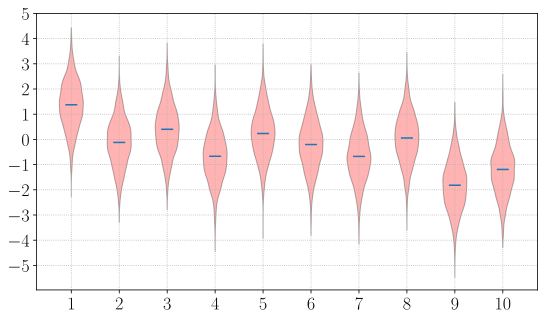

In [5]:
tb = Testbed(10, random_state=242)
idx = 11
print("Optimal action:", tb.optimal_action(idx) + 1)
print("Optimal mean reward:", tb.means[idx].max())
tb.plot(idx)

In [7]:
def train_eps_greedy_agent(eps, initial_value=0.0, alpha=None, n_steps=1000,
                           n_runs=2000, k=10, random_state=242, nonstationary=False):
    mean_rewards = [] 
    mean_optimal_actions = []

    tb = Testbed(k, initial_value, n_runs, random_state)
    for _ in range(n_steps):
        actions = tb.greedy_action(eps)
        optimals = (actions == tb.optimal_action())
        rewards = tb.step(actions, alpha, nonstationary)
        mean_rewards.append(rewards.mean())
        mean_optimal_actions.append(optimals.mean())
    
    return mean_rewards, mean_optimal_actions

def mean_rewards_and_optimal_actions(eps_list, initial_value=0.0, alpha=None, n_steps=1000,
                                     n_runs=2000, k=10, random_state=242, nonstationary=False):
    rewards_list = []
    optimal_actions_list = []
    for eps in eps_list:
        mean_rewards, mean_optimal_actions = train_eps_greedy_agent(
            eps, initial_value, alpha, n_steps, n_runs, k, random_state, nonstationary
        )
        rewards_list.append(mean_rewards)
        optimal_actions_list.append(mean_optimal_actions)
    return rewards_list, optimal_actions_list

In [13]:
%%time
eps_list = [0, 0.001, 0.01, 0.1, 0.5]
labels = [r"$\varepsilon = {}$".format(eps) for eps in eps_list]
rewards_list, optimal_action_list = mean_rewards_and_optimal_actions(eps_list, n_steps=5000)

CPU times: user 15.2 s, sys: 266 ms, total: 15.5 s
Wall time: 16.9 s


In [9]:
def plot_mean_rewards(mean_rewards, labels, max_step=1000):
    colors = ['r', 'b', 'g', 'm', 'brown', 'orange']
    plt.figure(figsize=(10, 6))
    for i, rewards in enumerate(mean_rewards):
        plt.plot(rewards[:max_step], c=colors[i], label=labels[i]);
        plt.title("Average rewards")
    # plt.ylim(0.5, 1.5)
    plt.xlim(0, max_step)
    plt.xlabel("time steps")
    plt.grid(ls=':')
    plt.legend()
    plt.show()

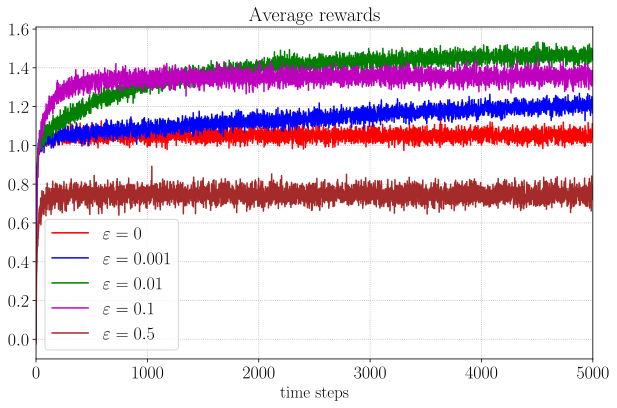

In [14]:
plot_mean_rewards(rewards_list, labels, 5000)

In [11]:
def plot_mean_optimal_actions(optimal_actions, labels, max_step=1000):
    colors = ['r', 'b', 'g', 'm', 'brown', 'orange']
    plt.figure(figsize=(10, 6))
    for i, actions in enumerate(optimal_actions):
        plt.plot(actions[:max_step], c=colors[i], label=labels[i]);
    plt.title("Percentage of optimal actions")
    # plt.ylim(0.5, 1.5)
    plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 101, 10))
    plt.xlim(0, max_step)
    plt.xlabel("time steps")
    plt.ylabel(r"$\%$")
    plt.grid(ls=':')
    plt.legend()
    plt.show()

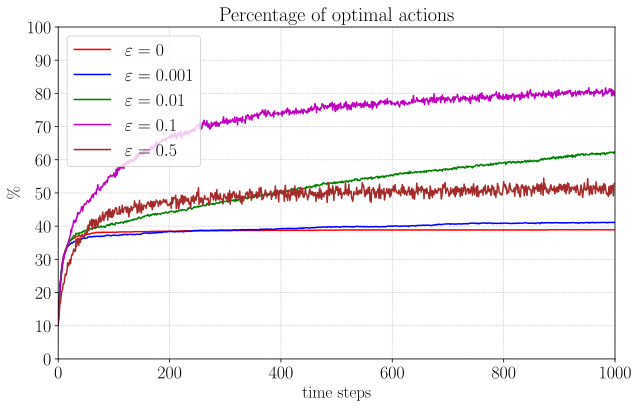

In [15]:
plot_mean_optimal_actions(optimal_action_list, labels, 1000)

**Q.** What is the cumulative regret of $\varepsilon$-greedy policy for a single testbed? Calculate

$$
    \lim\limits_{t\to\infty} \frac 1t \sum\limits_{i=1}^t \Delta_{A_i} \text{ and }
    \lim\limits_{t\to\infty} \frac 1t \sum\limits_{i=1}^t \mathbb P(A_i = a_*)
$$

if all the actions $A_i$ are selected according to $\varepsilon$-greedy policy.

## Optimistic initial value

Putting $Q_1(a)=5$ for all actions will encourage the exploration in the first steps.

In [21]:
%%time
rewards_opt_0_const, actions_opt_0_const = train_eps_greedy_agent(0.0, 5.0, 0.1, n_steps=2000)
rewards_opt_01, actions_opt_01 = train_eps_greedy_agent(0.1, 5.0, n_steps=2000)
rewards_01_const, actions_01_const = train_eps_greedy_agent(0.1, 0.0, alpha=0.1, n_steps=2000)

CPU times: user 3.42 s, sys: 46.2 ms, total: 3.47 s
Wall time: 3.66 s


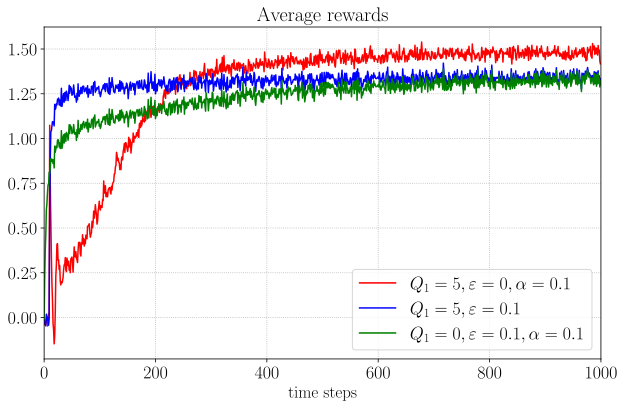

In [23]:
labels = [r"$Q_1=5, \varepsilon=0, \alpha=0.1$", r"$Q_1=5, \varepsilon=0.1$", r"$Q_1=0, \varepsilon=0.1, \alpha=0.1$"]
plot_mean_rewards([rewards_opt_0_const, rewards_opt_01, rewards_01_const], labels, 1000)

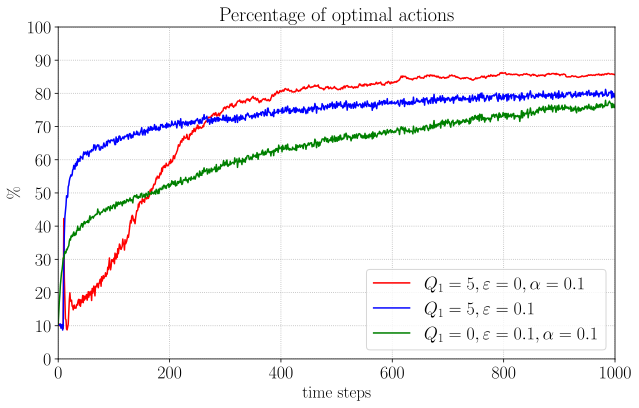

In [20]:
plot_mean_optimal_actions([actions_opt_0_const, actions_opt_01, actions_01_const], labels, 1000)

## Upper Confidence Bound

$$
A_t = \arg\max\limits_a \bigg\{Q_t(a) + c\sqrt{\frac{\log t}{N_t(a)}}\bigg\}
$$
For more information about this mysterious formula see
* Sutton&Barto, chapter 2.7
* [Lecture 2](https://www.youtube.com/watch?v=aQJP3Z2Ho8U&list=PLqYmG7hTraZDVH599EItlEWsUOsJbAodm&index=2&t=3100s) from DeepMind, 53:20 — 1:10:00

In [24]:
def train_ucb_agent(c, n_steps=1000, n_runs=2000, k=10, random_state=242):
    mean_rewards = [] 
    mean_optimal_actions = []

    tb = Testbed(k, 0, n_runs, random_state)
    for t in range(n_steps):
        actions = tb.ucb_action(t + 1, c)
        optimals = (actions == tb.optimal_action())
        rewards = tb.step(actions)
        mean_rewards.append(rewards.mean())
        mean_optimal_actions.append(optimals.mean())
    
    return mean_rewards, mean_optimal_actions

In [30]:
%%time
rewards_eps, optimals_eps = train_eps_greedy_agent(0.1, n_steps=1000)
rewards_ucb_1, optimals_ucb_1 = train_ucb_agent(1, n_steps=1000)
rewards_ucb_2, optimals_ucb_2 = train_ucb_agent(2, n_steps=1000)

CPU times: user 2.12 s, sys: 55.4 ms, total: 2.18 s
Wall time: 2.51 s


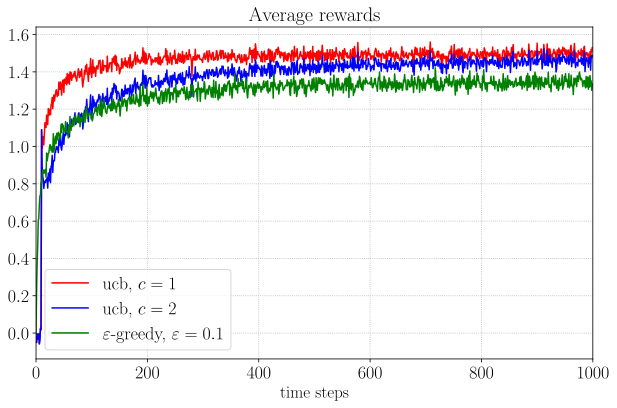

In [31]:
labels = [r"ucb, $c=1$", r"ucb, $c=2$", r"$\varepsilon$-greedy, $\varepsilon=0.1$"]
plot_mean_rewards([rewards_ucb_1, rewards_ucb_2, rewards_eps], labels, 1000)

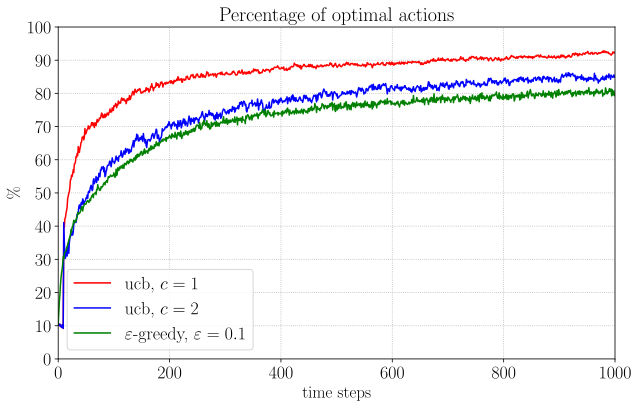

In [32]:
plot_mean_optimal_actions([optimals_ucb_1, optimals_ucb_2, optimals_eps], labels, 1000)